In [1]:
from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -50% !important; margin-right: -50% !important; }</style>"))

# Introduction
This project analyzes biodiversity data from the National Park Service to better understand species conservation status, endangerment patterns across categories, and observation trends in national parks. The analysis uses descriptive statistics, visualizations, and basic statistical inference to highlight potential risks to biodiversity and inform conservation priorities.

## Scoping

### Project Goals
The primary objective is to act as a biodiversity analyst supporting the National Park Service in monitoring at-risk species and maintaining park biodiversity. Key questions addressed include:

- What is the distribution of conservation status for species?  
- Are certain types of species more likely to be endangered or protected?  
- Are the observed differences in conservation status across species categories statistically significant?  
- Which species are most prevalent (highest observation counts) and how are their sightings distributed across parks?

### Data
Both datasets were provided by Codecademy:  
- `species_info.csv`: Contains species details (category, scientific_name, common_names, conservation_status).  
- `observations.csv`: Contains 7-day observation counts per species per park (scientific_name, park_name, observations).  

Note: The data for this project is *inspired* by real NPS data but is mostly fictional.

### Analysis
Descriptive statistics and data visualization techniques were used to explore distributions, relationships, and patterns. Key steps and metrics included:

- Calculated total observations per species by aggregating across parks  
- Created a binary `protected` flag (True if conservation_status is not NaN / "Not Listed")  
- Computed counts and proportions of protected species by category  
- Visualized observation distributions (histograms) per category, split by protected status  
- Produced bar charts showing protected species counts and proportions by category  
- Examined top observed species and observation volume patterns  

Statistical inference (planned): Chi-square test to determine if differences in protection rates across categories are significant.

### Evaluation
The analysis successfully addressed three of the four main questions:  
- Distribution of conservation status (mostly "Not Listed", with "Species of Concern" as the dominant listed status)  
- Likelihood of endangerment/protection by category (mammals and birds show noticeably higher proportions protected)  
- Observation patterns (protected species tend to have lower average total observations; certain categories dominate sightings)  

The statistical significance question remains partially open — a chi-square test on category vs. protected flag is recommended as the next step to confirm whether differences are meaningful or due to chance.

Key learnings:  
- The majority of species (~97%) are not listed as protected, but mammals and birds account for a disproportionate share of protected species.  
- Observation volume is highly skewed — most species are rarely seen, with a long tail of very common ones.  
- Protected species appear to be observed less frequently on average, which may indicate monitoring challenges or lower population sizes.

Limitations:  
- Data is fictional/inspired, so real-world inferences are limited.  
- No date data. The data is assumed to be within seven day observation periods.   
- No direct population size or threat data — protection status is the only risk indicator. Protection status is vague. For example, a non-protected species is listed as NaN. Which could imply a species has an adequate population size, or there isn't enough evidence to declare one way or another. 


In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency, chi2
%matplotlib inline

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:,.0f}'.format)
sp = pd.read_csv('species_info.csv',encoding='utf-8')
obs = pd.read_csv('observations.csv', encoding='utf-8')

##### Data loaded. 
- Generally I think it's more valuable to load the entire data set and include a .describe() statement. Accessing the whole table can help later if manual checks are needed. 

In [5]:
print(sp.describe())
sp.head()

              category scientific_name        common_names conservation_status
count             5824            5824                5824                 191
unique               7            5541                5504                   4
top     Vascular Plant   Procyon lotor  Brachythecium Moss  Species of Concern
freq              4470               3                   7                 161


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [6]:
print(obs.describe())
obs.head()

       observations
count        23,296
mean            142
std              70
min               9
25%              86
50%             124
75%             195
max             321


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


##### EDA, data characteristics, and basic metrics. 

In [7]:
print(f"{sp.category.value_counts()}\n")
print(sp.conservation_status.value_counts())

category
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: count, dtype: int64

conservation_status
Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: count, dtype: int64


In [8]:
print(obs.park_name.value_counts())

park_name
Great Smoky Mountains National Park    5824
Yosemite National Park                 5824
Bryce National Park                    5824
Yellowstone National Park              5824
Name: count, dtype: int64


In [9]:
print(len(obs))
print(len(sp))

23296
5824


In [10]:
obs.shape

(23296, 3)

In [11]:
sp.shape

(5824, 4)

In [12]:
sp.conservation_status.unique()

array([nan, 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

In [13]:
#Checking for duplicates
obs_dupes = obs.duplicated()
sp_dupes = sp.duplicated()

In [14]:
print(obs_dupes.value_counts())
print(sp_dupes.value_counts()) #clean

False    23281
True        15
Name: count, dtype: int64
False    5824
Name: count, dtype: int64


In [15]:
print(obs[obs.duplicated() == True].to_string())

              scientific_name                            park_name  observations
7263   Echinochloa crus-galli  Great Smoky Mountains National Park            62
8710    Streptopelia decaocto            Yellowstone National Park           255
10038          Plantago major  Great Smoky Mountains National Park            90
10674           Arctium minus               Yosemite National Park           162
12381    Eleocharis palustris  Great Smoky Mountains National Park            62
13372     Hesperis matronalis                  Bryce National Park           124
16741       Prunella vulgaris  Great Smoky Mountains National Park            75
17378    Potentilla norvegica               Yosemite National Park           148
17577      Spilogale putorius            Yellowstone National Park           256
18141           Poa compressa  Great Smoky Mountains National Park            80
19392       Cichorium intybus            Yellowstone National Park           266
20294  Botrychium virginianu

##### NOTE: These duplicates can be ignored. 
- Duplicate park names, species names, and observation counts are reasonable. 


In [16]:
not_at_risk = sp['conservation_status'].isnull().sum()
at_risk = sp['conservation_status'].notnull().sum()

In [17]:
not_at_risk

np.int64(5633)

In [18]:
at_risk

np.int64(191)

### Observation Summary Thus Far:
- Both data sets appear clean but limited in scope.
- Duplicates don't present any data quality issues.
- NaNs/Null values could imply not enough data was gathered. For practical reasons I'll make the assumption that NaN conservation_status implies a species is not at risk.
- Total species 'at risk' is 191 and species not at risk totals to 5,633. 

### Searching for insights:

In [19]:
obs_agg = obs.groupby('scientific_name')['observations'].sum().reset_index()
obs_agg.rename(columns={'observations': 'total_observations'}, inplace=True)
sp_obs = pd.merge(sp, obs_agg, on='scientific_name', how='left')
sp_obs['total_observations'] = sp_obs['total_observations'].fillna(0)

In [20]:
sp_obs.head()

,category,scientific_name,common_names,conservation_status,total_observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,615
1,Mammal,Bos bison,"American Bison, Bison",NaN,542
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN,514
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN,542
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN,1218


In [21]:
categoryparks = sp_obs.groupby(['category', 'conservation_status'])['total_observations'].mean()

In [22]:
print(categoryparks)

category           conservation_status
Amphibian          Endangered            144
                   Species of Concern    511
                   Threatened            282
Bird               Endangered            144
                   In Recovery           464
                   Species of Concern    566
Fish               Endangered            152
                   Species of Concern    527
                   Threatened            411
Mammal             Endangered            311
                   In Recovery           715
                   Species of Concern    774
                   Threatened            289
Nonvascular Plant  Species of Concern    541
Reptile            Species of Concern    507
Vascular Plant     Endangered            162
                   Species of Concern    515
                   Threatened            276
Name: total_observations, dtype: float64


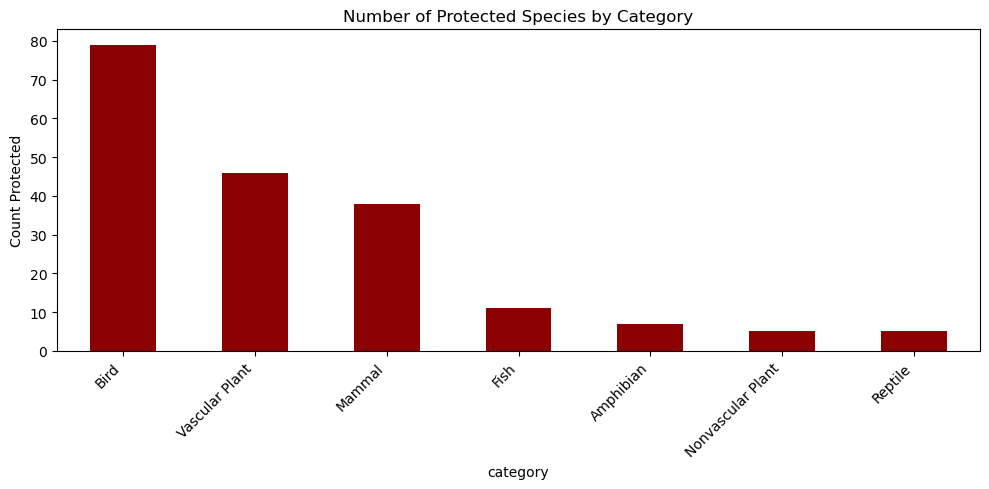

In [23]:
sp_obs['protected'] = sp_obs['conservation_status'].notna()

protected_counts = sp_obs.groupby('category')['protected'].sum().sort_values(ascending=False)

protected_counts.plot(kind='bar', figsize=(10,5), color='darkred')
plt.title('Number of Protected Species by Category')
plt.ylabel('Count Protected')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

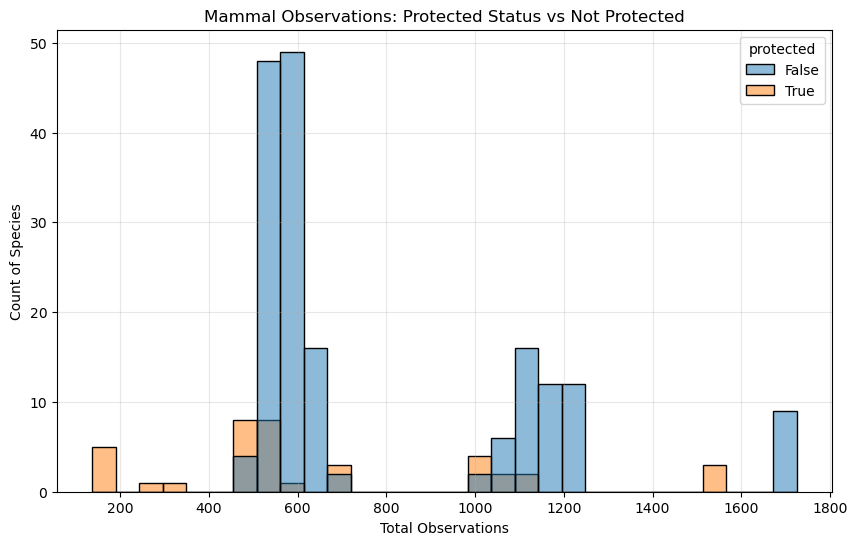

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Mammal'], x='total_observations', hue='protected', bins=30)
plt.title('Mammal Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

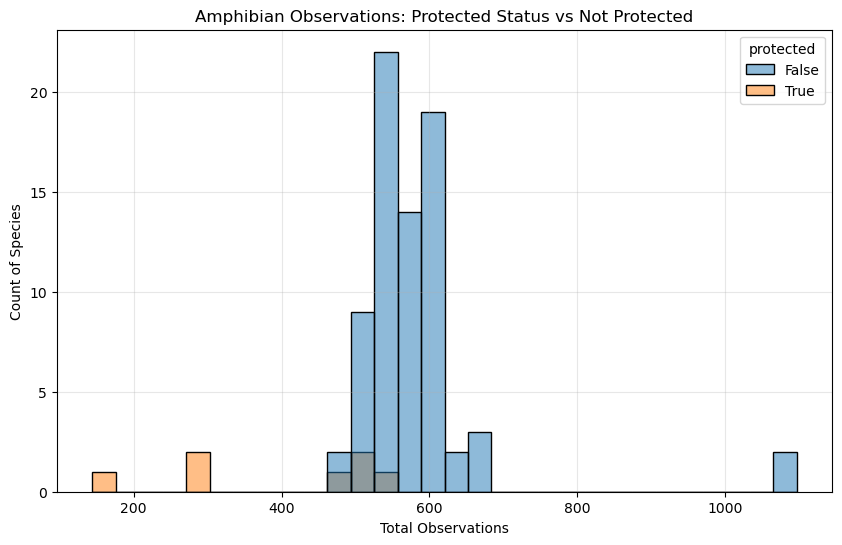

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Amphibian'], x='total_observations', hue='protected', bins=30)
plt.title('Amphibian Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

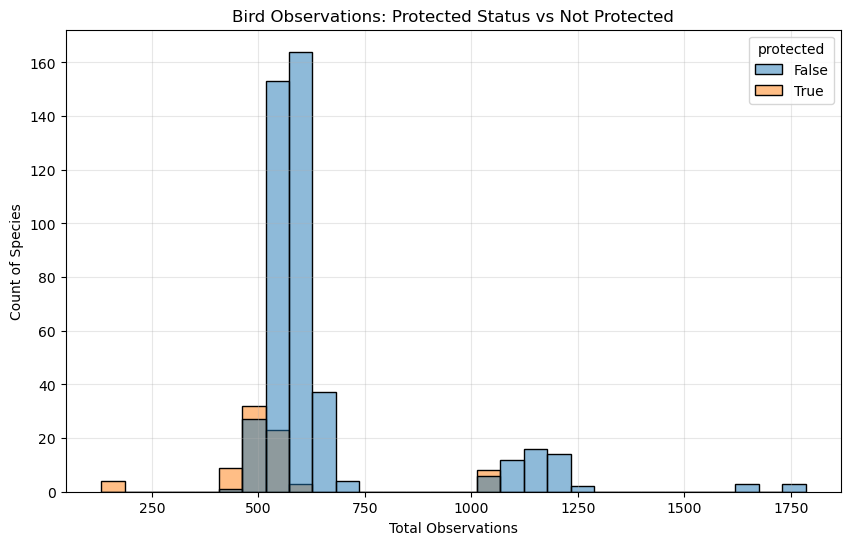

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Bird'], x='total_observations', hue='protected', bins=30)
plt.title('Bird Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

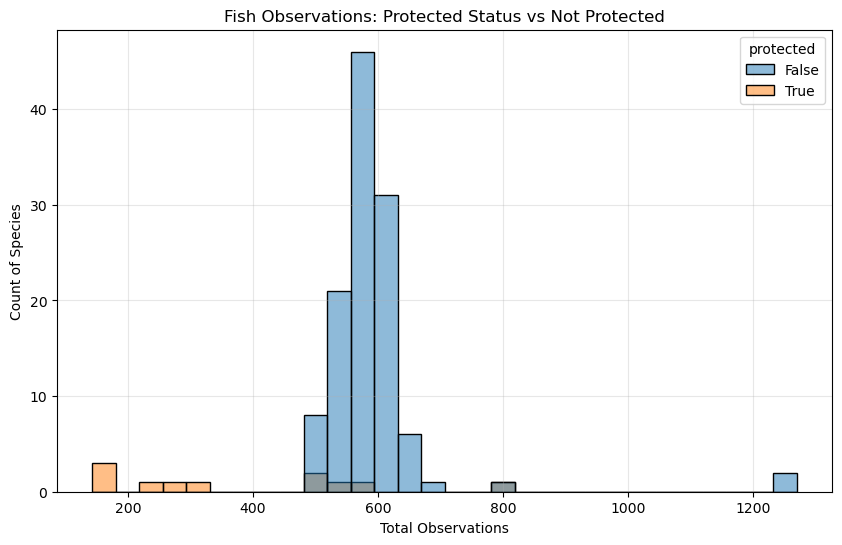

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Fish'], x='total_observations', hue='protected', bins=30)
plt.title('Fish Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

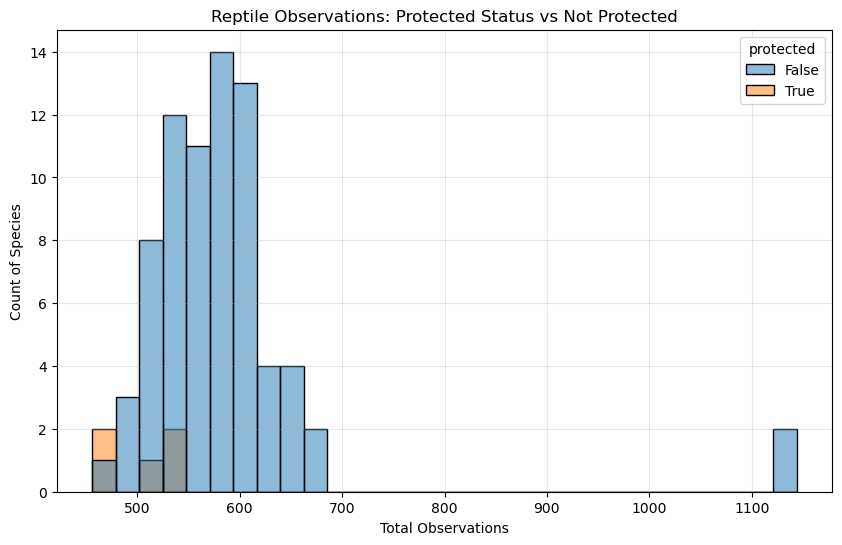

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Reptile'], x='total_observations', hue='protected', bins=30)
plt.title('Reptile Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

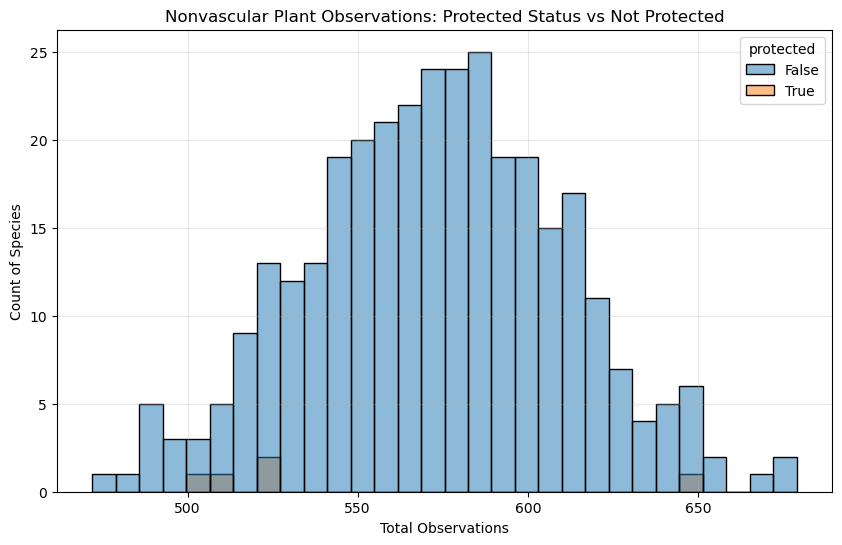

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Nonvascular Plant'], x='total_observations', hue='protected', bins=30)
plt.title('Nonvascular Plant Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

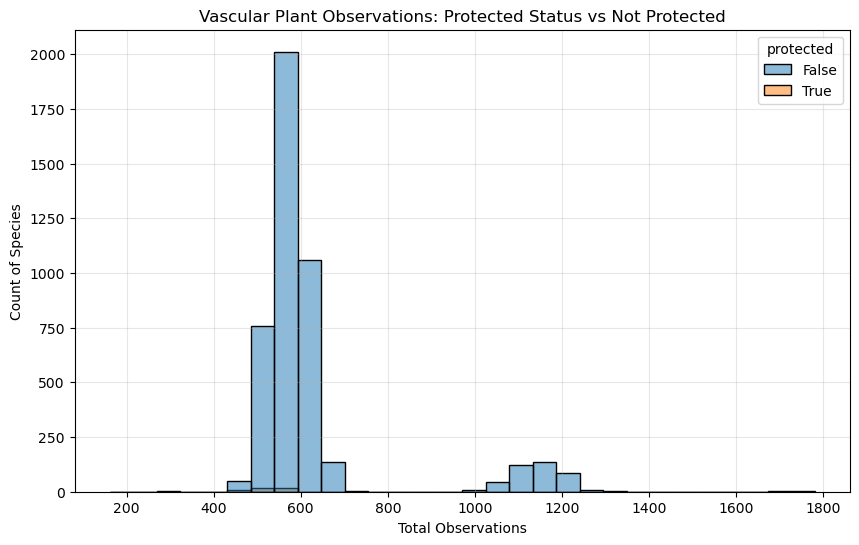

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sp_obs[sp_obs['category'] == 'Vascular Plant'], x='total_observations', hue='protected', bins=30)
plt.title('Vascular Plant Observations: Protected Status vs Not Protected')
plt.xlabel('Total Observations')
plt.ylabel('Count of Species')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
df = pd.merge(obs, sp, on='scientific_name', how='left')

print(df.head(20).to_string())

                        scientific_name                            park_name  observations           category                        common_names conservation_status
0                    Vicia benghalensis  Great Smoky Mountains National Park            68     Vascular Plant  Purple Vetch, Reddish Tufted Vetch                 NaN
1                        Neovison vison  Great Smoky Mountains National Park            77             Mammal                       American Mink                 NaN
2                     Prunus subcordata               Yosemite National Park           138     Vascular Plant                        Klamath Plum                 NaN
3                  Abutilon theophrasti                  Bryce National Park            84     Vascular Plant                          Velvetleaf                 NaN
4              Githopsis specularioides  Great Smoky Mountains National Park            85     Vascular Plant                      Common Bluecup                 NaN
5   

In [32]:
categories_per_park = df.groupby(['category', 'park_name', 'conservation_status'])['observations'].mean()

In [33]:
sum_categories_per_park = df.groupby(['category', 'park_name', 'conservation_status'])['observations'].sum()

In [34]:
#Creating another protected vs no protection status dataframes on the merged table.
protected = df[df['conservation_status'].notna()]
nonprotected = df[df['conservation_status'].isna()]

#### Insights: 
- With some visualizations, views, metrics and new variables the above gives us an intuitive starting point for more tests.

#### Next up: 
- Running Chi Square test.
- H_0: Conservation status is independent of animal category. 
- H_1: Organism category is related to conservation status.
- Alpha = 0.05

In [35]:
protected_freq = pd.crosstab(protected.category, protected.conservation_status)

In [36]:
chi2, pval, dof, expected = chi2_contingency(protected_freq) 

In [37]:
print(pval) #High confidence of relationship. Reject H_0

2.7594442674479634e-49


In [38]:
protected_freq

conservation_status,Endangered,In Recovery,Species of Concern,Threatened
category,,,,
Amphibian,4,0,16,8
Bird,16,12,320,0
Fish,12,0,16,20
Mammal,44,12,168,8
Nonvascular Plant,0,0,20,0
Reptile,0,0,20,0
Vascular Plant,4,0,172,8


In [39]:
#More evidence to reject Null Hypothesis
print(chi2) 
print(dof )
print(expected)

281.6928573184134
18
[[  2.54545455   0.76363636  23.29090909   1.4       ]
 [ 31.63636364   9.49090909 289.47272727  17.4       ]
 [  4.36363636   1.30909091  39.92727273   2.4       ]
 [ 21.09090909   6.32727273 192.98181818  11.6       ]
 [  1.81818182   0.54545455  16.63636364   1.        ]
 [  1.81818182   0.54545455  16.63636364   1.        ]
 [ 16.72727273   5.01818182 153.05454545   9.2       ]]


## Conclusions

This analysis examined biodiversity data from the National Park Service to understand species conservation status, endangerment patterns, and observation trends.

Key findings:
- The majority of species are not listed as protected (conservation_status = NaN / "Not Listed").
- Among the protected minority, "Species of Concern" is the most common status.
- Certain categories are significantly more likely to be protected: mammals and birds show noticeably higher proportions of protected species compared to vascular plants, nonvascular plants, reptiles, fish, and amphibians. 
- Observation volume is highly skewed: most species have low total observations, with a long tail of commonly sighted ones. Protected species tend to have lower average observations overall, possibly due to smaller populations or monitoring challenges.

These results were expected in broad strokes (mammals/birds more protected due to visibility and known threats).

Limitations:
- The data is fictional.
- Conceptually, a weeks worth of observations does not seem robust enough to make a conclusion on whether a species is thriving or not.

Overall, the analysis supports the hypothesis that species category carries an inherent conservation risk. 

### Extras:
- I wanted to try out at least one ML algroithm for the first time. 

In [40]:
df['is_protected'] = df['conservation_status'].notna().astype(int)   # 1 = protected, 0 = not
features = ['category', 'park_name', 'observations']
X = df[features]
y = df['is_protected']
print(X.isna().sum()) 
print(X.dtypes)

category        0
park_name       0
observations    0
dtype: int64
category        object
park_name       object
observations     int64
dtype: object


In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y,
    test_size=0.2,          # 20% for testing, 80% for training
    random_state=42,        # makes split reproducible
    stratify=y              # important: keeps same % protected in train & test
)

print("Train shape:", xtrain.shape)
print("Test shape:", xtest.shape)
print("Protected % in train:", ytrain.mean().round(3))
print("Protected % in test:", ytest.mean().round(3))

Train shape: (20505, 3)
Test shape: (5127, 3)
Protected % in train: 0.034
Protected % in test: 0.034


In [42]:
#Preprocessing
categorical_cols = ['category', 'park_name']   # the two string columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough'  # keep 'observations' as-is (numeric)
)

In [43]:
xtrain_encoded = preprocessor.fit_transform(xtrain)
xtest_encoded = preprocessor.transform(xtest)

print("Encoded train shape:", xtrain_encoded.shape)   # should be wider now
# 7. Train a simple model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,     # number of trees
    random_state=42,
    class_weight='balanced'  
)

Encoded train shape: (20505, 12)


In [44]:
model.fit(xtrain_encoded, ytrain)
print("Model trained")
# 8. Quick evaluation
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(xtest_encoded)

print("Accuracy:", accuracy_score(ytest, y_pred))
print("\nClassification Report:")
print(classification_report(ytest, y_pred, target_names=['Not Protected', 'Protected']))

Model trained
Accuracy: 0.914569923932124

Classification Report:
               precision    recall  f1-score   support

Not Protected       0.98      0.93      0.95      4951
    Protected       0.21      0.54      0.30       176

     accuracy                           0.91      5127
    macro avg       0.60      0.73      0.63      5127
 weighted avg       0.96      0.91      0.93      5127



In [46]:
top_species = df.groupby('scientific_name').agg({
    'observations': 'sum',
    'category': 'first',
    'common_names': 'first'
}).sort_values('observations', ascending=False).head(5)

top_species

,observations,category,common_names
scientific_name,,,
Streptopelia decaocto,5355,Bird,Eurasian Collared-Dove
Holcus lanatus,5340,Vascular Plant,"Common Velvet Grass, Velvetgrass"
Castor canadensis,5175,Mammal,"American Beaver, Beaver"
Hypochaeris radicata,5160,Vascular Plant,"Cat's Ear, Spotted Cat's-Ear"
Puma concolor,5133,Mammal,Panther (Mountain Lion)


<Figure size 640x480 with 0 Axes>

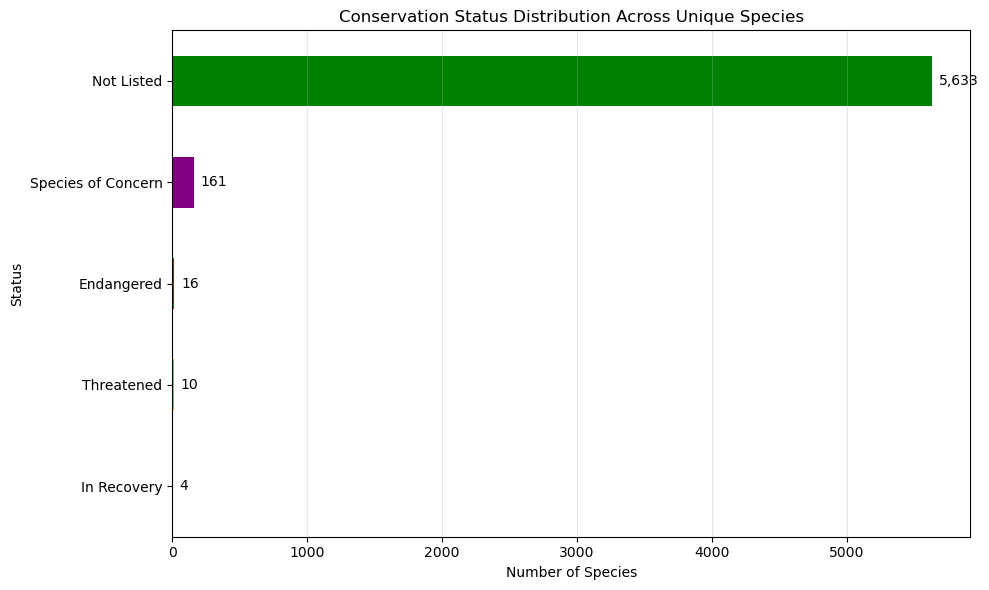

In [54]:
status_counts = sp['conservation_status'].value_counts(dropna=False)
status_counts = status_counts.rename(index={np.nan: 'Not Listed'})
plt.figure(figsize=(10, 6))

bars = status_counts.sort_values().plot(kind='barh', color=['lightgray', 'orange', 'red', 'purple', 'green'])

plt.title('Conservation Status Distribution Across Unique Species')
plt.xlabel('Number of Species')
plt.ylabel('Status')
plt.grid(axis='x', alpha=0.3)

for bar in bars.patches:
    width = bar.get_width() 
    plt.text(width + 50, bar.get_y() + bar.get_height()/2, f'{int(width):,}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()
plt.clf()